<a href="https://www.kaggle.com/code/page0526/med-segmentation?scriptVersionId=245086997" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cài đặt thư viện

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas
import cv2
import glob
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Preprocess data

Đây là bài toán phân đoạn tổn thương về da

In [ ]:
from pathlib import Path
from typing import List, Dict, Tuple, Union, Optional

# Define dataset
class SkinDataset(Dataset):
    def __init__(self, 
                 data_dir: str="/kaggle/input/skin-segmentation/Dataset/Train/Image", 
                 mask_dir: str="/kaggle/input/skin-segmentation/Dataset/Train/Mask", 
                 transform=None, 
                 # mask_transform=None, 
                 test: bool=False):
        self.data_dirs = list(Path(data_dir).glob("*.jpg"))
        self.transform = transform
        # self.mask_transform = mask_transform
        self.mask_dirs = mask_dir
        self.test = test

    def __len__(self):
        return len(self.data_dirs)

    def __getitem__(self, idx):
        im_path = self.data_dirs[idx]
        im = Image.open(im_path).convert("RGB")
        name = os.path.splitext(os.path.basename(im_path))[0]

        im = np.array(im)
        if not self.test:
            mask_path = os.path.join(self.mask_dirs, name + ".png")
            mask = Image.open(mask_path).convert('L')
            mask = np.array(mask)
            augmented = self.transform(image=im, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask / 255.0
            mask = (mask > 0.5).float()
            return image, mask
            
        if self.test and self.transform:
            im = self.transform(im)
            return im

        return name, im

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(512, 512),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
mask_transform = transforms.Compose([
    A.Resize(384, 384),
    ToTensorV2()
])

augmented_transform = A.Compose([
    # A.LongestMaxSize(max_size=image_height),
    # A.PadIfNeeded(min_height=image_height, min_width=image_width, border_mode=0),
    A.Resize(256,256, interpolation=cv2.INTER_NEAREST),

    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.0, 0.05),
        rotate=(-10, 10),
        shear=(-5, 5),
        p=0.5
    ),
    
    A.OneOf([
        A.ElasticTransform(alpha=1, sigma=50, p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.5),
    ], p=0.3),

    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    ], p=0.4),

    A.OneOf([
        A.GaussNoise(p=1.0),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=1.0)
    ], p=0.3),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
    
])

dataset = SkinDataset(transform=transform)
dataset[0][0].shape, dataset[0][1].shape, len(dataset)

Trực quan hóa một số hình ảnh từ dataset

In [ ]:
import random 

def visualize(num, dataset, figsize=(15, 5), cols=3):
    rows = (num + cols - 1)//cols
    plt.figure(figsize=figsize)
    indices = random.sample(range(len(dataset)), num)
    for i, idx in enumerate(indices):
        im, mask = dataset[idx]

        if hasattr(im, 'numpy'):
            im = im.numpy()
        if hasattr(mask, 'numpy'):
            mask = mask.numpy()

        if im.ndim == 3 and im.shape[0] in [1, 3]:
            im = np.transpose(im, (1, 2, 0))
        if mask.ndim == 3 and mask.shape[0] in [1, 3]:
            mask = np.transpose(mask, (1, 2, 0))

        plt.subplot(rows, cols * 2, i * 2 + 1)
        plt.imshow(im.astype(np.uint8) if im.dtype in [np.uint8] else im)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(rows, cols * 2, i * 2 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
visualize(num=10, dataset=dataset)

# Model Architecture

## Pretrained from torchvision libraries

In [ ]:
val_ratio = 0.3
SEED = 42
BATCHSIZE = 8
WORKERS = 2
WANDB = True
EPOCHS = 30

In [ ]:
from torchvision.io.image import decode_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)

model.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

preprocess = A.Compose([
    A.Resize(512, 512),
    ToTensorV2(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

In [ ]:
from torch.utils.data import random_split


total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size
generator = torch.Generator().manual_seed(SEED)
trainset, valset = random_split(dataset, [train_size, val_size], generator=generator)
print(f"Total: {total_size}, Train: {len(trainset)}, Val: {len(valset)}")
trainloader = DataLoader(trainset, batch_size = BATCHSIZE, shuffle=True, num_workers = WORKERS)
valloader = DataLoader(valset, batch_size = BATCHSIZE, shuffle=False, num_workers = WORKERS)

In [ ]:
image, mask = next(iter(trainloader))
output = model(image)['out']
probs = torch.sigmoid(output)
preds = (probs > 0.5).float()
preds.shape

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 384, 384))

## Unet
Unet là một kiểu kiến trúc CNN thiết kế đặc biệt cho bài toán phân đoạn ảnh y tế. Unet cũng gồm có hai thành phần chính giống với Variational AutoEncoder (VAE) là Encoder và Decoder nhưng có thêm skip connections. Nhờ skip connections, các đặc trưng từ encoder được nối tới decoder, cho phép Unet giữ lại các chi tiết cục bộ mà không làm mất mát thông tin khi giảm kích thước ảnh.

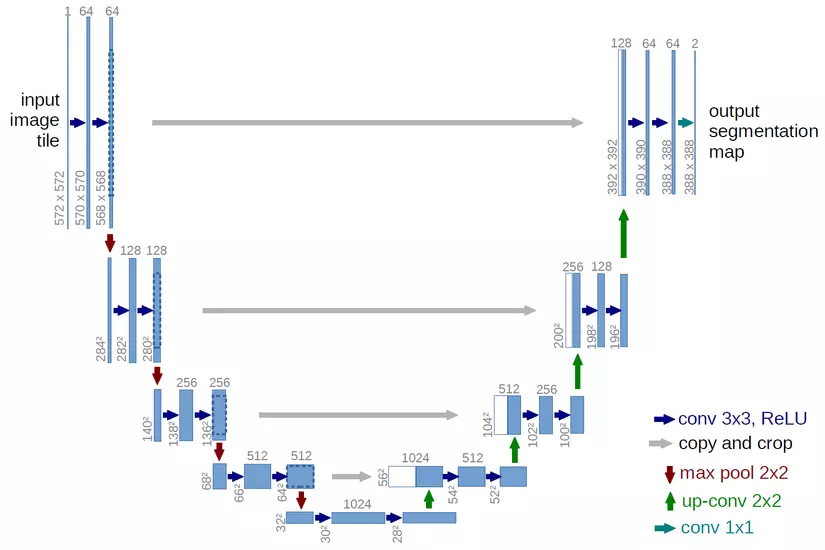
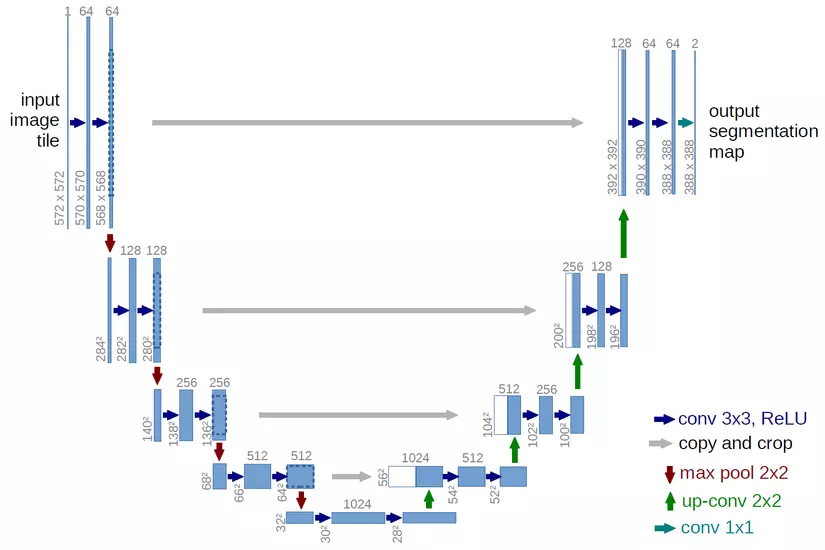

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported 'up_sample_mode' (can take one of 'conv_transpose' or 'bilinear'")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class Unet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(Unet, self).__init__()
        self.up_sample_mode = up_sample_mode

        # Downsampling
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)

        # Upsampling
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode)

        # Final convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)

        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)

        return x

In [ ]:
from torchinfo import summary

model = Unet()
summary(model, input_size=(1, 3, 256, 256))

## QTSeg
Mô hình QTSeg là mô hình kết hợp giữa CNN và Transformer, thiết kế để khắc phục các điểm yếu sau của Unet:
- Unet chủ yếu học đặc trưng cục bộ do bản chất của CNN, QTSeg khắc phục bằng cách sử dụng Dual-Mix Attention Decoder (DMAD).
- DMAD bao gồm các thành phần sau
  - Spatial Attention Module: học thông tin trên toàn bộ không gian ảnh
  - Channel Attention Block: học các liên hệ giữa các kênh đặc trưng
  - Cross-Attention: kết hợp thông tin giữa query tokens và các mức đặc trưng khác nhau
QTSeg vừa tận dụng phần Encoder của Unet để trích xuất đặc trưng cục bộ tốt, đồng thời bổ sung thêm attention để học các đặc trưng toàn cục, do đó cho kết quả tốt hơn Unet, chính vì vậy mà em lựa chọn mô hình này cho bài toán.

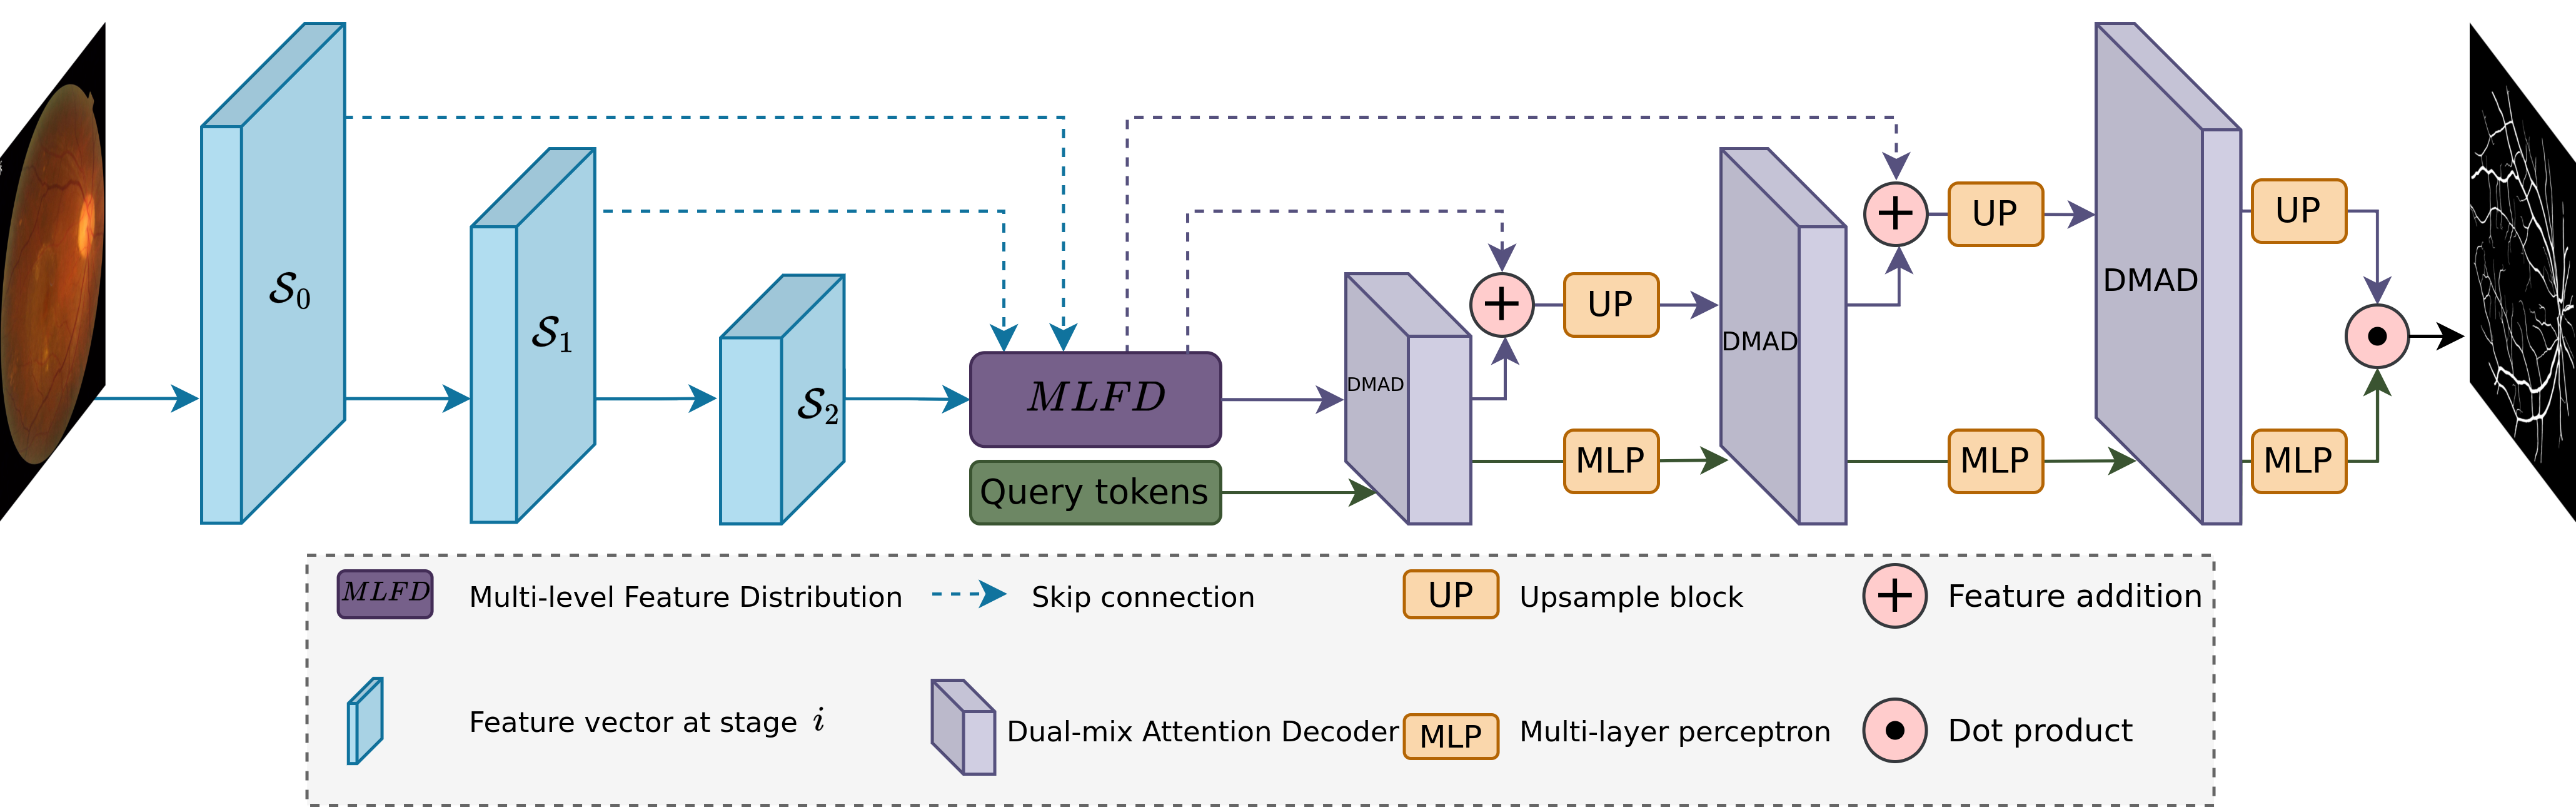
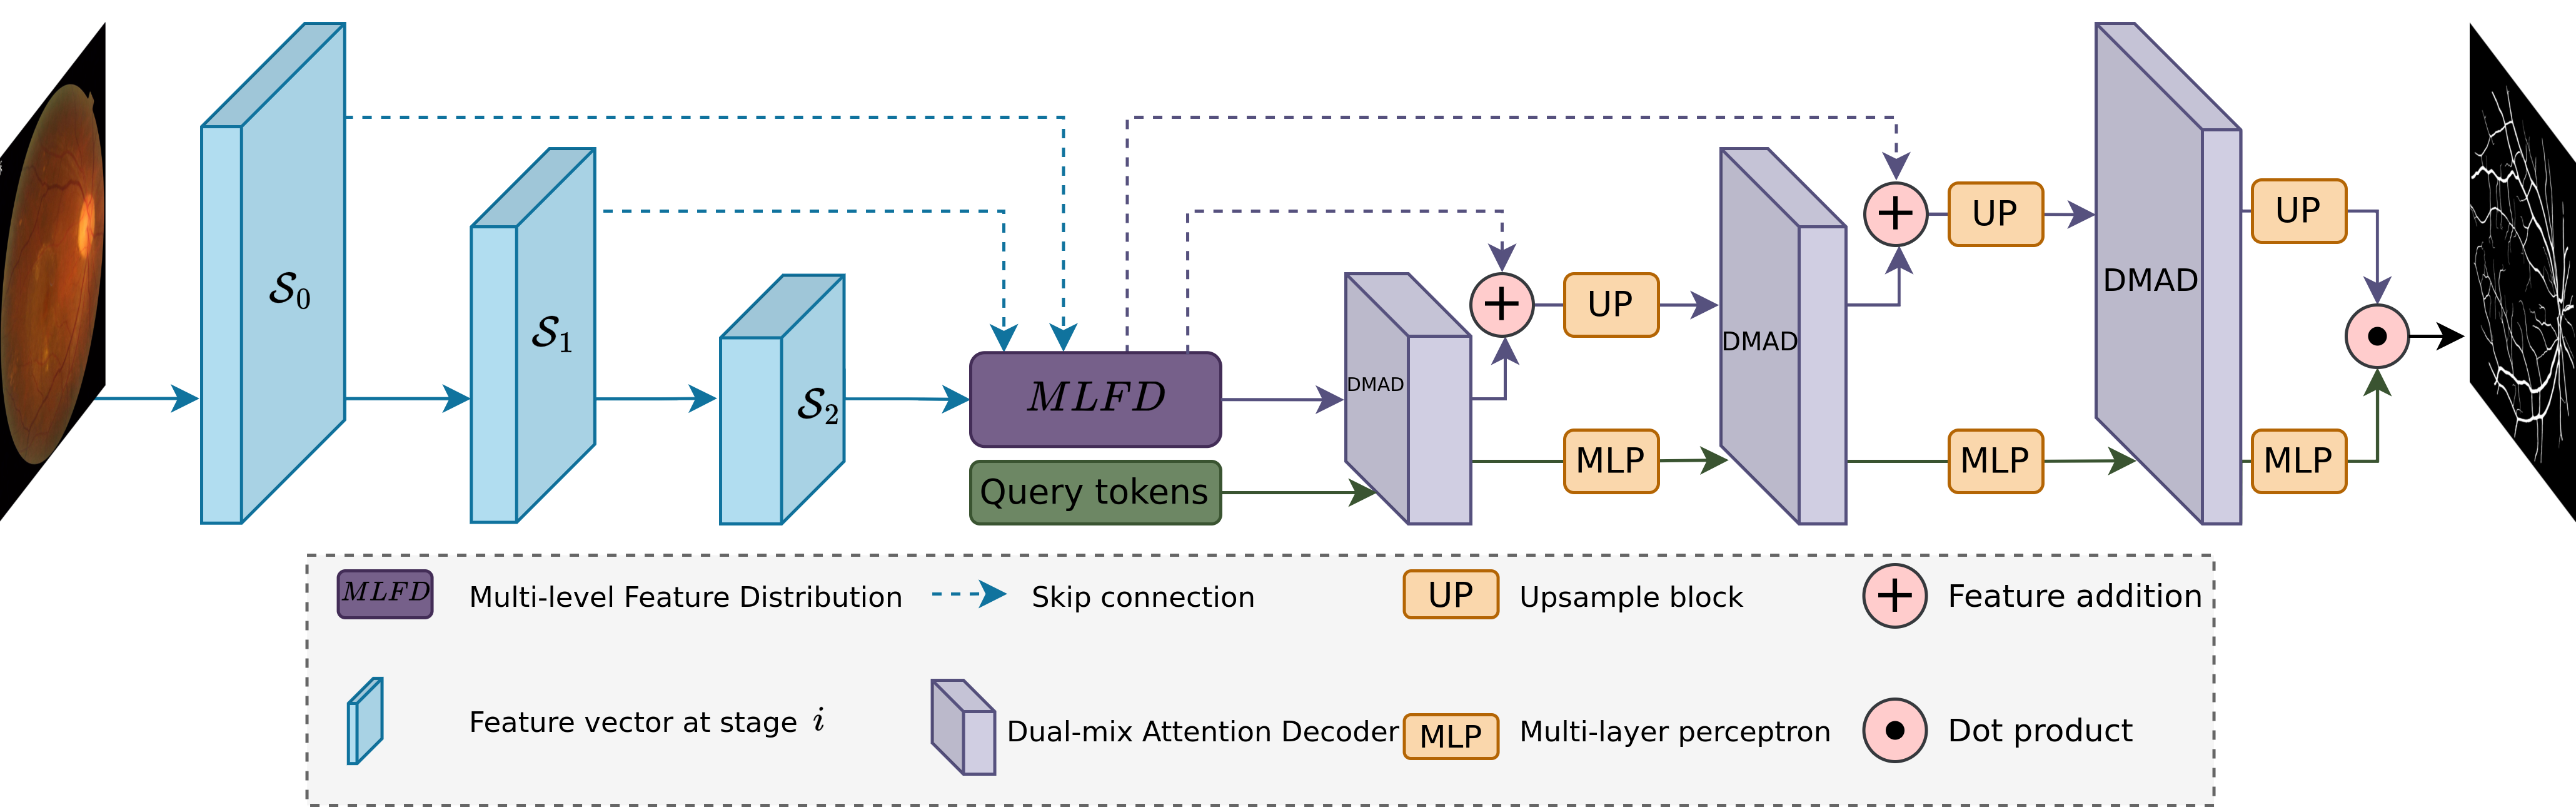
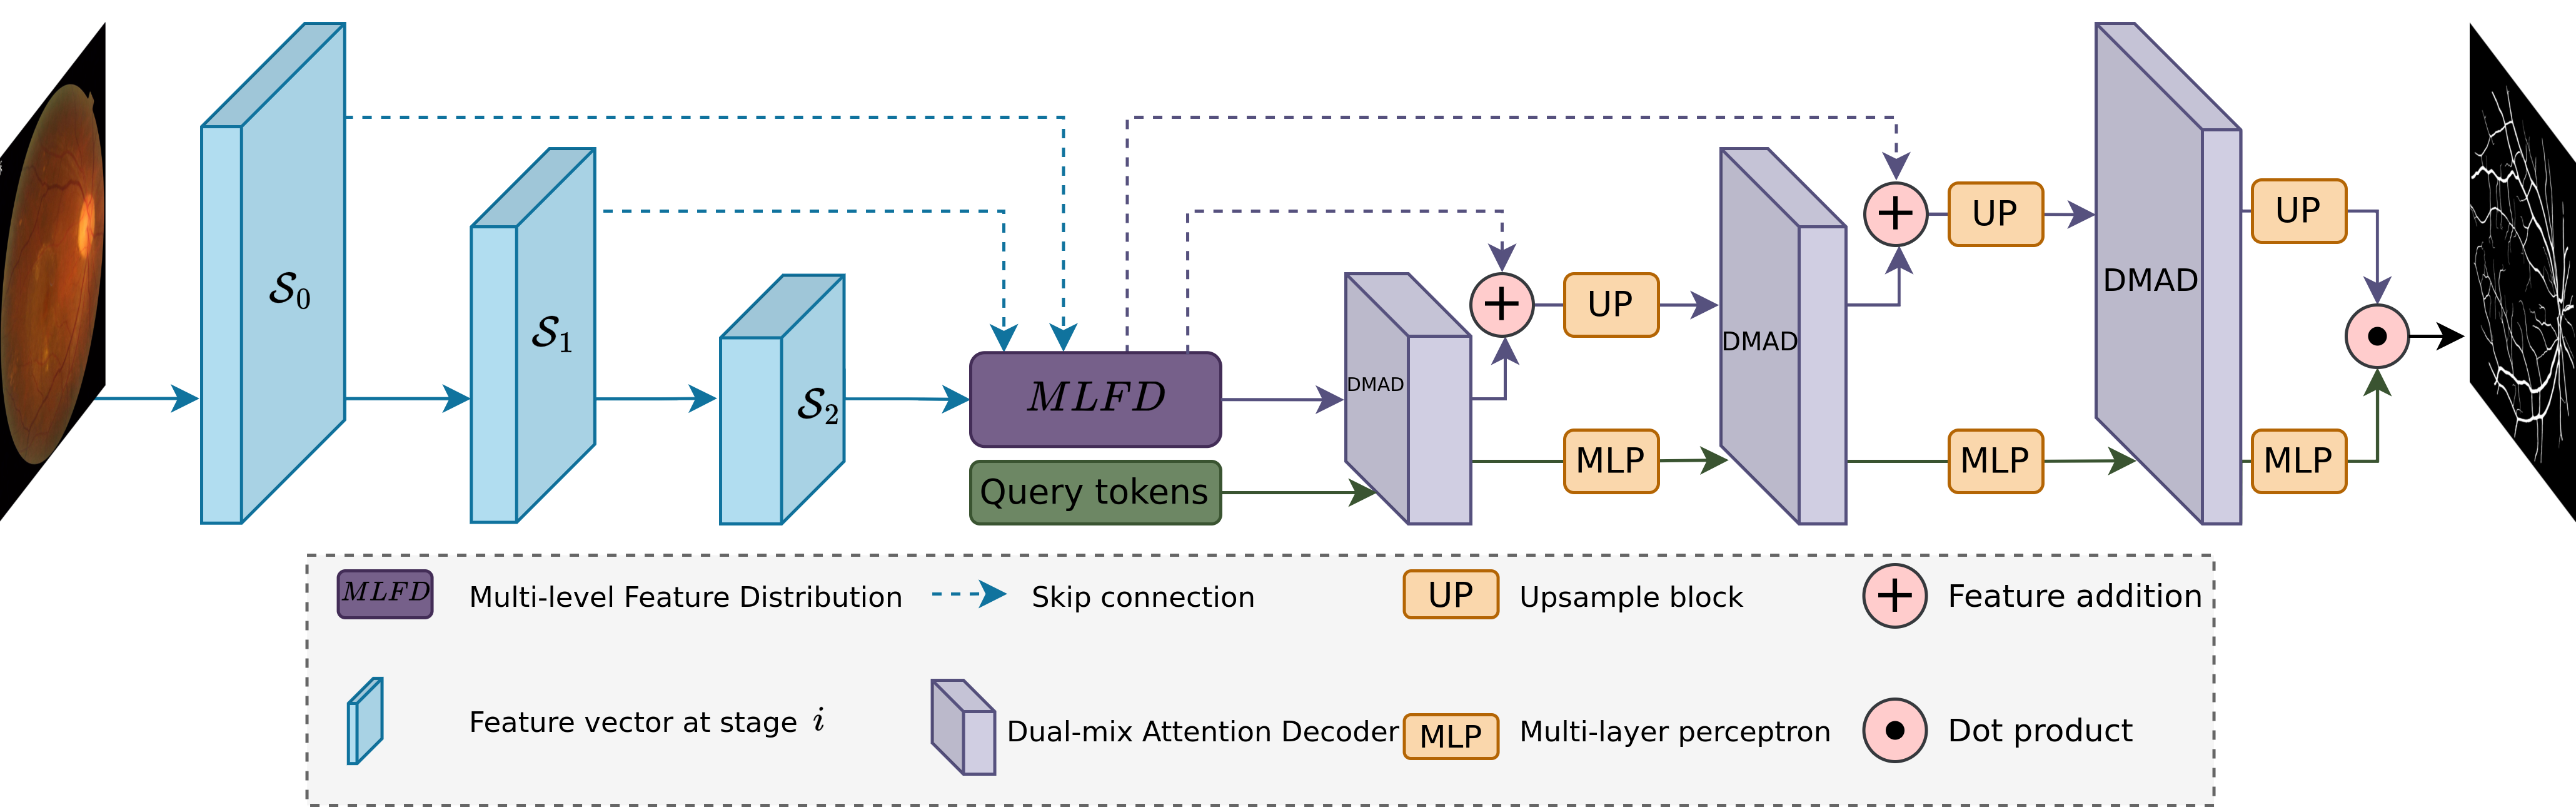
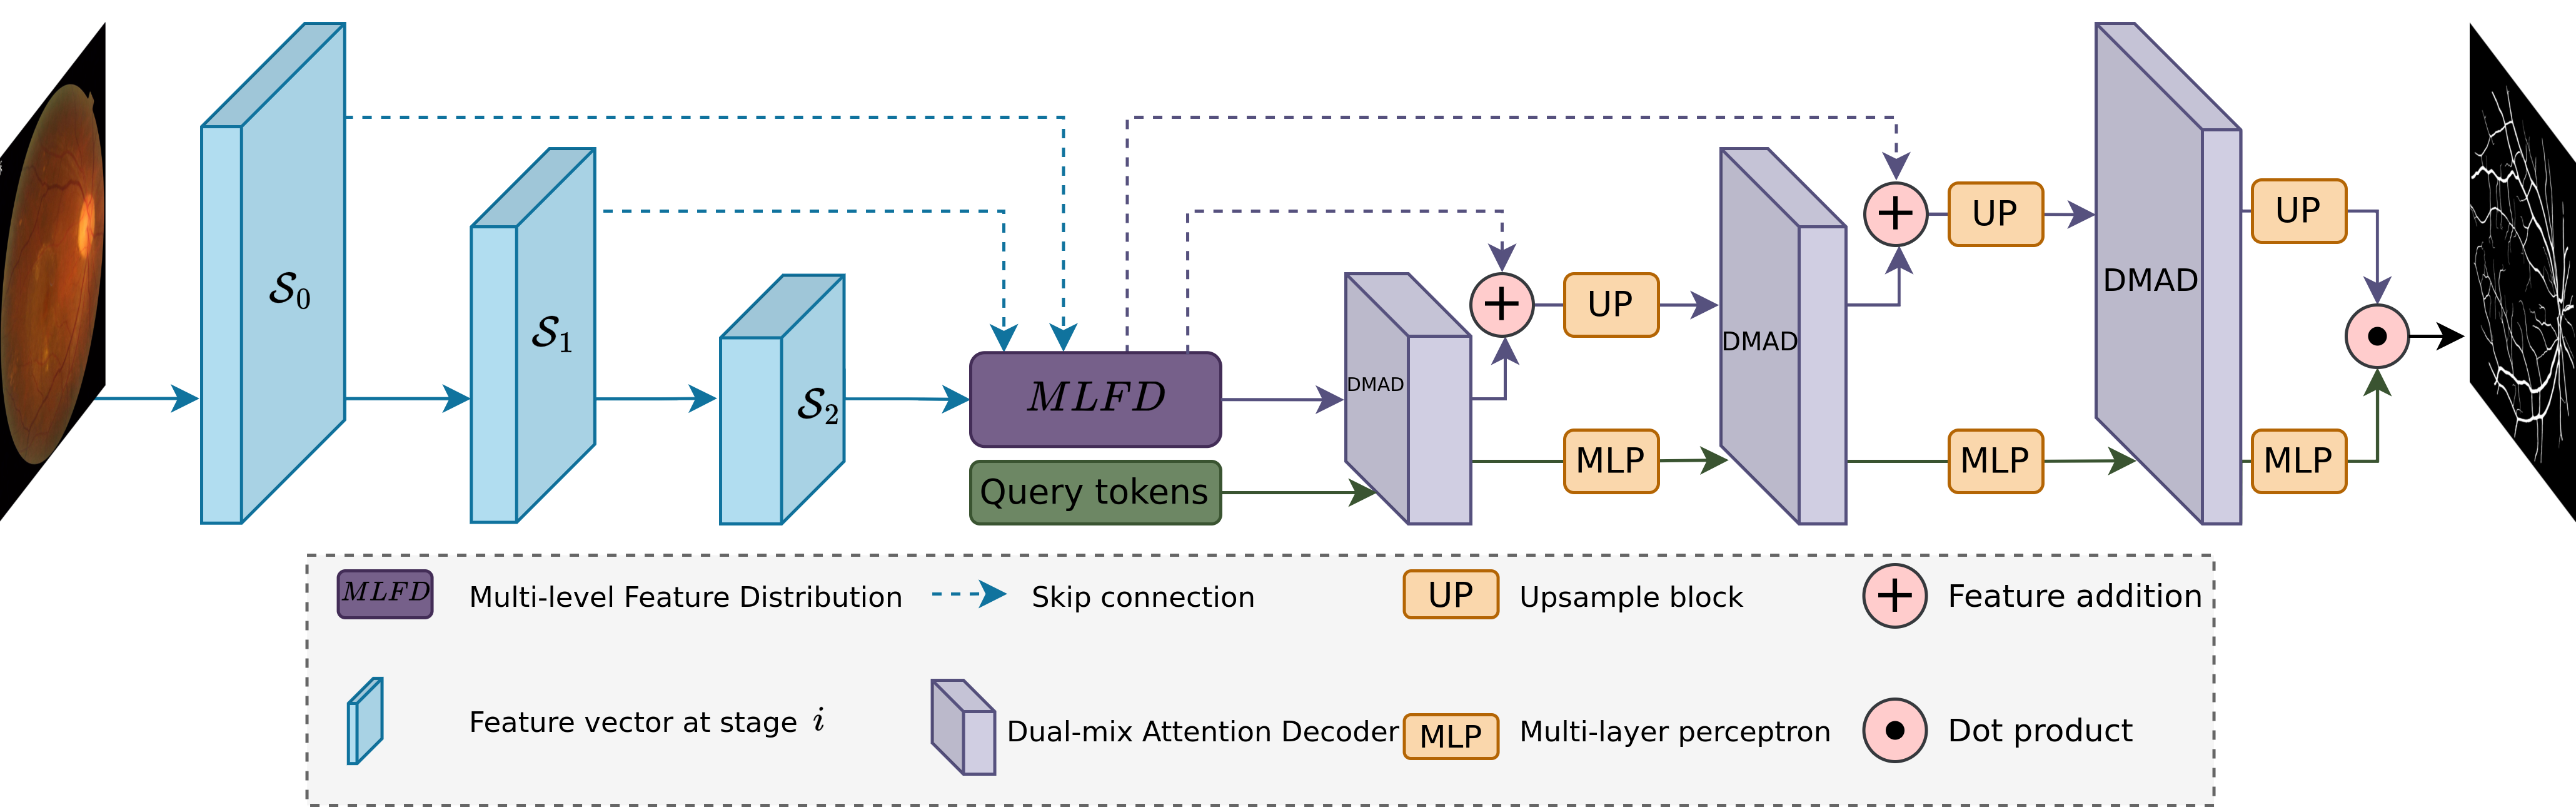

In [ ]:
!git clone https://github.com/tpnam0901/QTSeg.git

In [ ]:
import sys
sys.path.append('/kaggle/working/QTSeg')
%cd QTSeg
%pip install -r requirements.txt

In [ ]:
import logging
import os
from abc import ABC, abstractmethod
from typing import Tuple, List, Union
import importlib
import sys
import json
import cv2


class Base(ABC):
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    @abstractmethod
    def show(self):
        pass

    @abstractmethod
    def save(self, save_folder: str):
        pass

    @abstractmethod
    def load(self, cfg_path: str):
        pass


class BaseConfig(Base):
    def __init__(self, **kwargs):
        super(BaseConfig, self).__init__(**kwargs)

    def show(self):
        for key, value in self.__dict__.items():
            logging.info(f"{key}: {value}")

    def save(self, save_folder: str):
        os.makedirs(os.path.join(save_folder), exist_ok=True)
        out_cfg = os.path.join(save_folder, "cfg.json")
        with open(out_cfg, "w") as f:
            json.dump(self.get_params(), f, indent=4)

    def get_params(self):
        return self.__dict__

    def load(self, cfg_path: str):
        with open(cfg_path, "r") as f:
            data_dict = json.load(f)
        for key, value in data_dict.items():
            setattr(self, key, value)


class Config(BaseConfig):
    # Base
    def __init__(self, **kwargs):
        super(Config, self).__init__(**kwargs)
        self.name = "default"
        self.set_args()
        for key, value in kwargs.items():
            setattr(self, key, value)

    def set_args(self, **kwargs):
        # --------------------------------- Training settings
        self.epochs: int = 100
        self.val_epoch_freq: int = 1
        self.transfer_epochs: int = 50
        self.batch_size: int = 8
        self.log_freq: int = 40
        self.checkpoint_dir: str = "/kaggle/working/checkpoints"
        self.ckpt_save_fred: int = 5000
        self.use_amp: bool = False

        # --------------------------------- Optim settings
        # sgd, adamw
        self.optimizer: str = "adamw"
        self.momentum: float = 0.99
        self.betas: Tuple[float, float] = (0.9, 0.999)
        self.eps: float = 1e-08
        self.amsgard: bool = False
        self.nesterov: bool = True

        # --------------------------------- Scheduler settings
        # StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts, IdentityScheduler, PolyLR
        self.scheduler: str = "StepLR"
        self.learning_rate: float = 0.001
        self.learning_rate_min: float = 0.00001
        self.weight_decay: float = 3e-05
        self.scheduler_last_epoch: int = -1
        # StepLR
        self.lr_step_size: int = 50
        self.lr_step_gamma: float = 0.5
        # MultiStepLR
        self.lr_milestones: List[int] = [50, 100, 150, 200]
        self.lr_multistep_gamma: float = 0.1
        # ExponentialLR
        self.lr_exp_gamma: float = 0.99
        # CosineAnnealingLR
        self.lr_T_max: int = 50
        self.lr_eta_min: float = 0.00001
        # ReduceLROnPlateau
        self.lr_plateau_mode: str = "min"
        self.lr_plateau_factor: float = 0.1
        self.lr_plateau_patience: int = 10
        self.lr_plateau_threshold: float = 0.0001
        self.lr_plateau_threshold_mode: str = "rel"
        self.lr_plateau_cooldown: int = 0
        self.lr_plateau_min_lr: float = 0
        self.lr_plateau_eps: float = 1e-08
        # CosineAnnealingWarmRestarts
        self.lr_T_0: int = 50
        self.lr_T_mult: int = 2
        self.lr_eta_min: float = 1e-6
        # IdentityScheduler - No params, update every step

        # --------------------------------- Model settings
        self.model_type: str = "QTSeg"
        self.model_pretrained: str = ""
        self.img_size: int = 512
        self.image_embedding_size: Tuple[int, int] = (
            self.img_size // 16,
            self.img_size // 16,
        )

        # ----------------- Encoder settings
        self.encoder_model: str = "FPNEncoder"
        self.encoder_pretrained: str = "/kaggle/input/pretrained-encoder/pytorch/default/1/fpn-nano.pth"
        self.encoder_out_features: List[int] = [64, 128, 256]
        self.image_channel: int = 3
        self.n_channel: int = 16

        # ----------------- Bridge settings
        self.bridge_model: str = "MLFD"

        # ----------------- Decoder settings
        self.num_classes: int = 2  # Num classes
        self.decoder_model: str = "MaskDecoder"
        self.decoder_pretrained: str = ""
        self.mask_depths: List[int] = [1, 2, 3]
        self.mask_num_head: int = 8
        self.mask_mlp_dim: int = 2048

        # --------------------------------- Loss & Metric settings
        # Binary, MultiBinary
        self.metric = "Binary"
        # BCELoss, FocalLoss, CrossEntropyLoss, BinaryDiceLoss, CategoricalDiceLoss
        self.loss_type: List[str] = ["CrossEntropyLoss", "BinaryDiceLoss"]
        self.loss_weight: List[float] = [1.0, 1.0]

        self.focal_alpha: float = 0.25
        self.focal_gamma: float = 2
        self.lambda_value: float = 0.5
        self.dice_smooth: float = 1e-6

        # --------------------------------- Dataset
        # ISIC2016, BUSI, BKAI
        self.scale_value: float = 255.0
        self.cvtColor: Union[int, None] = None
        self.data_root: str = "working/dataset/ISIC2016"
        self.dataloader: str = "ISIC2016"
        self.valid_type: str = "test"
        self.num_workers: int = 8
        # Only used in BKAI for determining the location of the mask
        self.mask_type: str = ""

        # This SEED will be replaced at runtime and saved in the checkpoint
        self.SEED: int = 42

        self.name = self.model_type + "/" + self.encoder_model + self.decoder_model
        for key, value in kwargs.items():
            setattr(self, key, value)

In [ ]:
cfg = Config()

In [ ]:
sys.path.append('/kaggle/working/QTSeg/src')
from src.networks.models import QTSeg
from configs.base import Config

qtseg = QTSeg(cfg=cfg)

In [ ]:
state_dict = torch.load("/kaggle/input/qtseg/pytorch/default/1/weight_best_dice.pt", map_location='cpu')

qtseg.load_state_dict(state_dict, strict=True)

In [ ]:
im, mask = next(iter(trainloader))
im, mask = im.to(device), mask.to(device)
with torch.no_grad():
    qtseg.to('cuda')
    output = qtseg(im)
print(f"Output shape: {output}")

In [ ]:
import torch.nn.functional as F

logits = output[0]
probs = F.softmax(logits, dim=1)
pred_mask = probs.argmax(dim=1)
pred_mask.shape

# Training

## Train & Eval

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_key)

## UnetModule

In [ ]:
import pytorch_lightning as pl
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryAccuracy
from torchmetrics.segmentation import DiceScore
from torchvision.utils import make_grid

class UnetModule(pl.LightningModule):
    def __init__(self, net: nn.Module, lr: float=0.00008, weight_decay: float=1e-2, dice_weight: float=0.7):
        super().__init__()

        self.save_hyperparameters(ignore=['net'])

        self.net = net
        self.lr = lr
        self.weight_decay = weight_decay
        self.dice_weight = dice_weight

        self.criterion = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCEWithLogitsLoss()
        
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()

        self.train_dice = DiceScore(num_classes=1)
        self.val_dice = DiceScore(num_classes=1)
        self.test_dice = DiceScore(num_classes=1)

        self.train_precision = BinaryPrecision()
        self.val_precision = BinaryPrecision()
        self.test_precision = BinaryPrecision()

        self.train_recall = BinaryRecall()
        self.val_recall = BinaryRecall()
        self.test_recall = BinaryRecall()

        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()

    def computed_loss(self, logits, mask):
        probs = torch.sigmoid(logits)
        dice = self.criterion(probs, mask)
        bce = self.bce_loss(logits, mask)
        return self.dice_weight * dice + (1 - self.dice_weight) * bce
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        im, mask = batch
        outputs = self(im)
        outputs = outputs.squeeze(1)
        probs = torch.sigmoid(outputs)
        loss = self.copmuted_loss(outputs, mask)
        preds = (probs > 0.5).float()
        
        if mask.ndim == 4:
            mask = mask.unsqueeze(1)
            
        iou_score = self.train_iou(preds, mask)
        dice_score = self.train_dice(preds, mask)
        precision = self.train_precision(preds, mask)
        recall = self.train_recall(preds, mask)
        acc = self.train_acc(preds, mask)
        
        if batch_idx == 0 and self.logger:
            num = min(4, im.size(0))
            
            if preds.shape[1] == 1:
                preds_rgb = torch.cat([preds, preds, preds], dim=1)
                masks_rgb = torch.cat([mask, mask, mask], dim=1)
            else:
                masks_rgb = mask
                preds_rgb = preds
                
            masks_grid = make_grid(masks_rgb, normalize=True)
            preds_grid = make_grid(preds_rgb, normalize=True)
            ims_grid = make_grid(im, normalize=True)
        
            self.logger.log_image(key='train/image', images=[ims_grid, masks_grid, preds_grid], caption=['image', 'mask', 'pred'])
            
        self.log("train/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/iou", iou_score, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/dice", dice_score, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/precision", precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/recall", recall, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        im, mask = batch
        outputs = self(im)
        outputs = outputs.squeeze(1)
        probs = torch.sigmoid(outputs)
        loss = self.computed_loss(outputs, mask)
        preds = (probs > 0.5).float()
        
        if mask.ndim == 4:
            mask = mask.unsqueeze(1)
        
        iou_score = self.val_iou(preds, mask)
        dice_score = self.val_dice(preds, mask)
        precision = self.val_precision(preds, mask)
        recall = self.val_recall(preds, mask)
        acc = self.val_acc(preds, mask)
        
        if self.logger:
            num = min(4, im.size(0))
            
            if preds.shape[1] == 1:
                preds_rgb = torch.cat([preds, preds, preds], dim=1)
                masks_rgb = torch.cat([mask, mask, mask], dim=1)
            else:
                masks_rgb = mask
                preds_rgb = preds
                
            masks_grid = make_grid(masks_rgb, normalize=True)
            preds_grid = make_grid(preds_rgb, normalize=True)
            ims_grid = make_grid(im, normalize=True)
        
            self.logger.log_image(key='val/image', images=[ims_grid, masks_grid, preds_grid], caption=['image', 'mask', 'pred'])
        
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/iou", iou_score, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/dice", dice_score, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/precision", precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/recall", recall, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            im, mask = batch
            has_gt = True
        else:
            im = batch
            mask = None
            has_gt = False
        
        outputs = self(im)
        outputs = outputs.squeeze(1)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        
        if mask.ndim == 4:
            mask = mask.unsqueeze(1)
            
        if self.logger:
            
            if preds.shape[1] == 1:
                preds_rgb = torch.cat([preds, preds, preds], dim=1)
            else:
                preds_rgb = preds

            preds_grid = make_grid(preds_rgb, normalize=True)
            ims_grid = make_grid(im, normalize=True)
            images = [ims_grid, preds_grid]
            captions = ['image', 'pred']

            if has_gt:
                masks_rgb = torch.cat([mask, mask, mask], dim=1) if mask.shape[1] == 1 else mask
                masks_grid = make_grid(masks_rgb, normalize=True)
                images = [ims_grid, preds_grid, masks_grid]
                captions.append('mask')
                
            self.logger.log_image(key='test/image', images=images, caption=captions)

        if has_gt:
            loss = self.computed_loss(outputs, mask)
            iou_score = self.test_iou(preds, mask)
            dice_score = self.test_dice(preds, mask)
            precision = self.test_precision(preds, mask)
            recall = self.test_recall(preds, mask)
            acc = self.test_acc(preds, mask)
            
            self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
            self.log("test/iou", iou_score, on_step=False, on_epoch=True, prog_bar=True)
            self.log("test/dice", dice_score, on_step=False, on_epoch=True, prog_bar=True)
            self.log("test/precision", precision, on_step=False, on_epoch=True, prog_bar=True)
            self.log("test/recall", recall, on_step=False, on_epoch=True, prog_bar=True)
            self.log("test/accuracy", acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer =  torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay = self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val_loss",
           },
        }

## PretrainSegModule

In [ ]:
import pytorch_lightning as pl
import torch.nn as nn
import torch
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryAccuracy
from torchmetrics.segmentation import DiceScore


class PretrainedSegModule(pl.LightningModule):
    def __init__(self, net: nn.Module, lr: float = 0.00008, weight_decay: float = 1e-2, dice_weight: float=0.7, pos_weight: int=3.0):
        super().__init__()

        self.save_hyperparameters(ignore=['net'])

        self.net = net
        self.lr = lr
        self.weight_decay = weight_decay
        self.dice_weight = dice_weight

        self.criterion = smp.losses.DiceLoss(mode='binary')

        # pos_weight_tensor = torch.tensor(pos_weight)
        # self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()

        self.train_dice = DiceScore(num_classes=2)
        self.val_dice = DiceScore(num_classes=2)
        self.test_dice = DiceScore(num_classes=2)

        self.train_precision = BinaryPrecision()
        self.val_precision = BinaryPrecision()
        self.test_precision = BinaryPrecision()

        self.train_recall = BinaryRecall()
        self.val_recall = BinaryRecall()
        self.test_recall = BinaryRecall()

        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.test_acc = BinaryAccuracy()

    def forward(self, x):
        out = self.net(x)
        return out["out"] if isinstance(out, dict) else out

    def computed_loss(self, logits, mask):
        probs = torch.sigmoid(logits)
        dice = self.criterion(probs, mask)
        bce = self.bce_loss(logits, mask)
        return self.dice_weight * dice + (1 - self.dice_weight) * bce

    def shared_step(self, batch, batch_idx, stage: str):
        im, mask = batch
        logits = self(im)
        
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        if mask.ndim == 3:
            mask = mask.unsqueeze(1)

        loss = self.computed_loss(logits, mask)

        metrics = {
            f"{stage}/loss": loss,
            f"{stage}/iou": getattr(self, f"{stage}_iou")(preds, mask),
            f"{stage}/dice": getattr(self, f"{stage}_dice")(preds, mask),
            f"{stage}/precision": getattr(self, f"{stage}_precision")(preds, mask),
            f"{stage}/recall": getattr(self, f"{stage}_recall")(preds, mask),
            f"{stage}/accuracy": getattr(self, f"{stage}_acc")(preds, mask),
        }

        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)

        if stage in ["train", "val"] and self.logger:
            num = min(4, im.size(0))
            ims_grid = make_grid(im[:num], normalize=True)
            masks_rgb = torch.cat([mask[:num]] * 3, dim=1)
            preds_rgb = torch.cat([preds[:num]] * 3, dim=1)
            self.logger.log_image(key=f"{stage}/image", images=[ims_grid, masks_rgb, preds_rgb], caption=['image', 'mask', 'pred'])

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        im, mask = batch if isinstance(batch, (list, tuple)) and len(batch) == 2 else (batch, None)
        logits = self(im)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        if mask is not None and mask.ndim == 3:
            mask = mask.unsqueeze(1)

        if self.logger:
            ims_grid = make_grid(im, normalize=True)
            preds_rgb = torch.cat([preds] * 3, dim=1)
            images = [ims_grid, preds_rgb]
            captions = ["image", "pred"]
            if mask is not None:
                masks_rgb = torch.cat([mask] * 3, dim=1)
                images.append(masks_rgb)
                captions.append("mask")
            self.logger.log_image(key="test/image", images=images, caption=captions)

        if mask is not None:
            loss = self.criterion(probs, mask)
            self.log_dict({
                "test/loss": loss,
                "test/iou": self.test_iou(preds, mask),
                "test/dice": self.test_dice(preds, mask),
                "test/precision": self.test_precision(preds, mask),
                "test/recall": self.test_recall(preds, mask),
                "test/accuracy": self.test_acc(preds, mask),
            }, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.95)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val/loss"},
        }

In [ ]:
import pytorch_lightning as pl
import torch.nn as nn
import torch
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid
from torchmetrics.classification import (
    MulticlassJaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAccuracy
)
from torchmetrics.segmentation import DiceScore

class QTSegModule(pl.LightningModule):
    def __init__(self, net: nn.Module, lr: float = 0.00008, weight_decay: float = 1e-2, dice_weight: float = 1):
        super().__init__()
        self.save_hyperparameters(ignore=['net'])

        self.net = net
        self.lr = lr
        self.weight_decay = weight_decay
        self.dice_weight = dice_weight

        self.num_classes = 2
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')

        self.train_iou = MulticlassJaccardIndex(num_classes=self.num_classes)
        self.val_iou = MulticlassJaccardIndex(num_classes=self.num_classes)
        self.test_iou = MulticlassJaccardIndex(num_classes=self.num_classes)

        self.train_dice = DiceScore(num_classes=self.num_classes)
        self.val_dice = DiceScore(num_classes=self.num_classes)
        self.test_dice = DiceScore(num_classes=self.num_classes)

        self.train_precision = MulticlassPrecision(num_classes=self.num_classes, average='macro')
        self.val_precision = MulticlassPrecision(num_classes=self.num_classes, average='macro')
        self.test_precision = MulticlassPrecision(num_classes=self.num_classes, average='macro')

        self.train_recall = MulticlassRecall(num_classes=self.num_classes, average='macro')
        self.val_recall = MulticlassRecall(num_classes=self.num_classes, average='macro')
        self.test_recall = MulticlassRecall(num_classes=self.num_classes, average='macro')

        self.train_acc = MulticlassAccuracy(num_classes=self.num_classes, average='macro')
        self.val_acc = MulticlassAccuracy(num_classes=self.num_classes, average='macro')
        self.test_acc = MulticlassAccuracy(num_classes=self.num_classes, average='macro')

    def forward(self, x):
        output = self.net(x)
        if isinstance(output, (tuple, list)):
            logits = output[0]
        elif isinstance(output, dict):
            logits = output["out"]
        else:
            logits = output
        return logits

    def computed_loss(self, logits, mask):
        ce = self.ce_loss(logits, mask.squeeze(1).long())
        dice = self.dice_loss(logits, mask.squeeze(1).long())
        return self.dice_weight * dice + ce

    def shared_step(self, batch, batch_idx, stage: str):
        im, mask = batch
        logits = self(im)  # (B, C, H, W)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)  # (B, H, W)

        if mask.ndim == 3:
            mask = mask.unsqueeze(1)

        loss = self.computed_loss(logits, mask)

        metrics = {
            f"{stage}/loss": loss,
            f"{stage}/iou": getattr(self, f"{stage}_iou")(preds, mask.squeeze(1)),
            f"{stage}/dice": getattr(self, f"{stage}_dice")(preds, mask.squeeze(1)),
            f"{stage}/precision": getattr(self, f"{stage}_precision")(preds, mask.squeeze(1)),
            f"{stage}/recall": getattr(self, f"{stage}_recall")(preds, mask.squeeze(1)),
            f"{stage}/accuracy": getattr(self, f"{stage}_acc")(preds, mask.squeeze(1)),
        }

        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        
        if stage in ["train", "val"] and self.logger:
            num = min(4, im.size(0))
            ims_grid = make_grid(im[:num], normalize=True)
            masks_color = (mask[:num].squeeze(1).float() * (255.0 / self.num_classes)).byte()
            preds_color = (preds[:num].float() * (255.0 / self.num_classes)).byte()
            
            masks_rgb = masks_color.unsqueeze(1).repeat(1, 3, 1, 1)
            preds_rgb = preds_color.unsqueeze(1).repeat(1, 3, 1, 1)

            masks_grid = make_grid(masks_rgb, normalize=False)
            preds_grid = make_grid(preds_rgb, normalize=False)
            self.logger.log_image(key=f"{stage}/image", images=[ims_grid, masks_rgb, preds_rgb], caption=['image', 'mask', 'pred'])

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        im, mask = batch
        logits = self(im)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        if mask.ndim == 3:
            mask = mask.unsqueeze(1)

        if self.logger:
            preds = preds.unsqueeze(dim=1)
            ims_grid = make_grid(im, normalize=True)
            preds_color = (preds[:num].float() * (255.0 / self.num_classes)).byte()
            preds_rgb = preds_color.unsqueeze(1).repeat(1, 3, 1, 1)
            images = [ims_grid, preds_rgb]
            captions = ["image", "pred"]
            
            self.logger.log_image(key="test/image", images=images, caption=captions)

        loss = self.computed_loss(logits, mask)
        self.log_dict({
            "test/loss": loss,
            "test/iou": self.test_iou(preds, mask.squeeze(1)),
            "test/dice": self.test_dice(preds, mask.squeeze(1)),
            "test/precision": self.test_precision(preds, mask.squeeze(1)),
            "test/recall": self.test_recall(preds, mask.squeeze(1)),
            "test/accuracy": self.test_acc(preds, mask.squeeze(1)),
        }, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.95, step_size=50)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val/loss"},
        }

## Trainer

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


torch.use_deterministic_algorithms(False)

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

seed_everything(SEED, workers=True)
wandb_logger = WandbLogger(project='skin-segmentation', log_model=True) if WANDB else None
# module = UnetModule(model)
module = QTSegModule(net=qtseg)

checkpoint_cb = ModelCheckpoint(monitor='val/dice', save_top_k=1, mode='max')
early_stopping = EarlyStopping(monitor='val/dice', patience=10, mode='max', verbose=True)

trainer = Trainer(
    max_epochs=EPOCHS,
    logger=wandb_logger,
    callbacks=[checkpoint_cb, early_stopping],
    accelerator='auto',
    devices='auto',
    log_every_n_steps=10,
    deterministic=False
)

trainer.fit(module, trainloader, valloader)
trainer.save_checkpoint("best_model.ckpt", weights_only=True)

## Training without using Lightning

In [ ]:
import wandb

wandb.init(project="QTSeg-training", config=cfg.__dict__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim
import torchmetrics
import wandb
import torchvision.utils as vutils
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy, MulticlassF1Score

# Losses
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
qtseg.to(device)

# Optimizer
optimizer = optim.AdamW(qtseg.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg.lr_step_size, gamma=cfg.lr_step_gamma)

# Metrics
num_classes = cfg.num_classes
metric_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro').to(device)
metric_acc = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
metric_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
metric_dice = DiceScore(num_classes=num_classes, average='macro').to(device)

def decode_segmentation(mask, num_classes):
    """Convert class indices into RGB image (random colormap)."""
    colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    return colors[mask.cpu().numpy()]
    
@torch.no_grad()
def validate(model, valloader):
    qtseg.eval()
    total_loss, total_dice, total_ce = 0, 0, 0
    metric_iou.reset()
    metric_acc.reset()
    metric_f1.reset()
    metric_dice.reset()

    for images, masks in valloader:
        images, masks = images.to(device), masks.to(device).long()
        outputs = qtseg(images)
        if isinstance(outputs, (list, tuple)):
            outputs = outputs[0]

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        ce = ce_loss(outputs, masks)
        dice = dice_loss(outputs, masks)
        loss = cfg.loss_weight[0] * ce + cfg.loss_weight[1] * dice

        total_loss += loss.item()
        total_ce += ce.item()
        total_dice += dice.item()

        metric_iou.update(preds, masks)
        metric_acc.update(preds, masks)
        metric_f1.update(preds, masks)
        metric_dice.update(preds, masks)

    qtseg.train()
    n = len(valloader)
    return (
        total_loss / n,
        total_ce / n,
        total_dice / n,
        metric_iou.compute().item(),
        metric_acc.compute().item(),
        metric_f1.compute().item(),
        metric_dice.compute().item()
    )
    
# Training loop
for epoch in range(cfg.epochs):
    total_train_loss = 0
    for batch_idx, (images, masks) in enumerate(trainloader):
        images, masks = images.to(device), masks.to(device).long()

        optimizer.zero_grad()
        outputs = qtseg(images)
        if isinstance(outputs, (list, tuple)):
            outputs = outputs[0]

        loss_ce = ce_loss(outputs, masks)
        loss_dice = dice_loss(outputs, masks)
        loss = cfg.loss_weight[0] * loss_ce + cfg.loss_weight[1] * loss_dice

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        if (batch_idx + 1) % cfg.log_freq == 0:
            wandb.log({
                "train/loss": loss.item(),
                "train/ce_loss": loss_ce.item(),
                "train/dice_loss": loss_dice.item(),
                "lr": scheduler.get_last_lr()[0],
                "epoch": epoch,
                "step": epoch * len(trainloader) + batch_idx
            })

    scheduler.step()

    # Validation
    if (epoch + 1) % cfg.val_epoch_freq == 0:
        val_loss, val_ce, val_dice, val_iou, val_acc, val_f1, val_dice_score = validate(qtseg, valloader)
        wandb.log({
            "val/loss": val_loss,
            "val/ce_loss": val_ce,
            "val/dice_loss": val_dice,
            "val/mIoU": val_iou,
            "val/accuracy": val_acc,
            "val/f1_score": val_f1,
            "val/dice_score": val_dice_score,
            "epoch": epoch
        })
        print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss/len(trainloader):.4f} | "
          f"Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Acc: {val_acc:.4f} | "
          f"F1: {val_f1:.4f} | Dice: {val_dice_score:.4f}")

# Final model save
torch.save(qtseg.state_dict(), f"{cfg.checkpoint_dir}/qseg_final.pth")

[Kết quả huấn luyện mô hình](https://api.wandb.ai/links/iai-uet-vnu/12ip76y9)

In [ ]:
# wandb.finish()

# Inference

In [ ]:
original_testset = SkinDataset(data_dir='/kaggle/input/skin-segmentation/Dataset/Test/Image', test=True)
# testset = SkinDataset(data_dir='/kaggle/input/skin-segmentation/Dataset/Test/Image', transform=transform, test=True)
# testloader = DataLoader(testset, batch_size = BATCHSIZE, shuffle=True, num_workers = WORKERS)

# trainer.test(dataloaders=testloader)


if wandb.run is not None:
    # wandb_logger.experiment.save("checkpoints/*.ckpt")
    # wandb.save(checkpoint_cb.best_model_path)
    wandb.finish()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_and_mask(image: np.ndarray, mask: np.ndarray, mask_cmap: str = 'gray', title: str = ''):
    
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask.squeeze(axis=2)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image)
    axs[0].set_title(f"{title}Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap=mask_cmap)
    axs[1].set_title(f"{title}Mask")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
module = QTSegModule.load_from_checkpoint('/kaggle/working/QTSeg/QTSeg/best_model.ckpt', net=qtseg)

In [ ]:
def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

In [ ]:
# test one image
qtseg.eval()
name, image = original_testset[191]
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384))
])
shape = image.shape[:2]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformed_image = t(image).to(device)
module = module.to(device)

logit = module(transformed_image.unsqueeze(0))
probs = torch.softmax(logit, dim=1)
mask = torch.argmax(probs, dim=1)

resize = transforms.Resize(shape)
resized_mask = resize(mask)
resized_mask = resized_mask.permute(1, 2, 0)
resized_mask = resized_mask.squeeze().detach().cpu().numpy()
resized_mask = (resized_mask > 0.5).astype(np.uint8)
output = mask_to_rle(resized_mask)

In [ ]:
resized_mask.max(), resized_mask.min(), name

In [ ]:
show_image_and_mask(image, resized_mask)

In [ ]:
def visualize_all_predictions(module, dataset, input_size=(512, 512), save_dir=None, show=False):
    """
    Visualize and/or save predicted masks for all images in the test dataset.

    Args:
        module: Trained segmentation model.
        dataset: Dataset containing (name, image) pairs.
        input_size: Tuple of (height, width) for resizing.
        save_dir: If set, saves images to this directory.
        show: If True, displays images inline.
    """
    module.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    qtseg.to(device)

    t = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(input_size)
    ])

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for idx in range(len(dataset)):
        name, image = dataset[idx]
        shape = image.shape[:2]

        transformed_image = t(image).to(device)

        with torch.no_grad():
            logit = qtseg(transformed_image.unsqueeze(0))[0]
            probs = torch.softmax(logit, dim=1)
            mask = torch.argmax(probs, dim=1)

        resized_mask = transforms.Resize(shape)(mask.float().unsqueeze(0))
        resized_mask = resized_mask.squeeze().cpu().numpy().astype(np.uint8)

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].imshow(resized_mask, alpha=0.5, cmap='jet')
        axs[0].set_title(f"{name} Overlay")
        axs[0].axis("off")

        axs[1].imshow(resized_mask, cmap='gray')
        axs[1].set_title("Predicted Mask")
        axs[1].axis("off")

        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, f"{name}.png"))
            plt.close()
        elif show:
            plt.show()
        else:
            plt.close()

In [ ]:
visualize_all_predictions(qtseg, original_testset, show=True)

In [ ]:
from torchvision.transforms import InterpolationMode
def inference(dataset, module):
    module.eval()
    res = []
    t = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512))
    ])
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    module.to(device)

    with torch.no_grad():
        for i in range(len(dataset)):
            name, image = dataset[i]
            shape = image.shape[:2]

            transformed_image = t(image).to(device)
            logit = module(transformed_image.unsqueeze(0))  # [1, C, H, W]
            probs = torch.softmax(logit, dim=1)
            mask = torch.argmax(probs, dim=1)  # [1, H, W]

            # Resize mask back to original image shape
            resize = transforms.Resize(shape, interpolation=InterpolationMode.NEAREST)
            resized_mask = resize(mask)

            # Convert to numpy
            resized_mask = resized_mask.squeeze().cpu().numpy().astype(np.uint8)

            # For binary segmentation (assumes class 1 is foreground)
            if resized_mask.max() > 1:
                pass  # multiclass: keep as is
            else:
                resized_mask = (resized_mask == 1).astype(np.uint8)

            rle = mask_to_rle(resized_mask)
            res.append((name, rle))

    return res

In [ ]:
res = inference(original_testset, module)

In [ ]:
import csv

with open('submit.csv', 'w', newline='') as f:
    writer = csv.writer(f, quoting=csv.QUOTE_NONE, escapechar='\\')
    writer.writerow(['ID', 'Mask'])
    for id_str, rle_mask in res:
        writer.writerow([id_str, rle_mask])

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/working/QTSeg/submit.csv')

In [ ]:
df.describe()

In [ ]:
df.head()